In [160]:
# Problem 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
from sklearn.model_selection import train_test_split

# For this assignment, assume that every hidden layer has the same number of neurons.
NUM_HIDDEN_LAYERS = 3
NUM_INPUT = 784
NUM_HIDDEN = 10
NUM_OUTPUT = 10
lr = 0.1
# Unpack a list of weights and biases into their individual np.arrays.
def unpack (weightsAndBiases):
    # Unpack arguments
    Ws = []

    # Weight matrices
    start = 0
    end = NUM_INPUT*NUM_HIDDEN
    W = weightsAndBiases[start:end]
    Ws.append(W)

    for i in range(NUM_HIDDEN_LAYERS - 1):
        start = end
        end = end + NUM_HIDDEN*NUM_HIDDEN
        W = weightsAndBiases[start:end]
        Ws.append(W)

    start = end
    end = end + NUM_HIDDEN*NUM_OUTPUT
    W = weightsAndBiases[start:end]
    Ws.append(W)

    Ws[0] = Ws[0].reshape(NUM_HIDDEN, NUM_INPUT)
    for i in range(1, NUM_HIDDEN_LAYERS):
        # Convert from vectors into matrices
        Ws[i] = Ws[i].reshape(NUM_HIDDEN, NUM_HIDDEN)
    Ws[-1] = Ws[-1].reshape(NUM_OUTPUT, NUM_HIDDEN)

    # Bias terms
    bs = []
    start = end
    end = end + NUM_HIDDEN
    b = weightsAndBiases[start:end]
    bs.append(b)

    for i in range(NUM_HIDDEN_LAYERS - 1):
        start = end
        end = end + NUM_HIDDEN
        b = weightsAndBiases[start:end]
        bs.append(b)

    start = end
    end = end + NUM_OUTPUT
    b = weightsAndBiases[start:end]
    bs.append(b)
    return Ws, bs

def softmax(x):
    x = x - np.max(x)
    return np.exp(x)/np.sum(np.exp(x))

def relu(z):
  m = np.array([NUM_INPUT, NUM_HIDDEN])
  for j in range(NUM_INPUT):
      for i in range(NUM_HIDDEN):
              m = (max(0.0, z[j][i]))
  return m

def forward_prop (x, y, weightsAndBiases):
    Ws, bs = unpack(weightsAndBiases)
    zs = np.empty([NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN])
    hs = np.empty([NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN])
    loss = np.empty([NUM_HIDDEN_LAYERS, NUM_INPUT, 1])
    for i in range(NUM_HIDDEN_LAYERS):
        zs[i] = (np.matmul(Ws[0][i], np.transpose(x))+bs[0][i])
        hs[i] = (relu(zs[i]))
        part1 = -np.matmul(np.log(np.array(hs[i])), np.transpose(y))
        part2 = np.matmul(np.log(1-np.array(hs[i])), np.transpose(1-y),)
        loss[i] = (part1+part2)
    yhat = softmax(np.matmul(hs[NUM_HIDDEN_LAYERS-1], Ws[NUM_HIDDEN_LAYERS-1]) + bs[NUM_HIDDEN_LAYERS-1])
    # Return loss, pre-activations, post-activations, and predictions
    return loss, zs, hs, yhat

def back_prop (x, y, weightsAndBiases):
    loss, zs, hs, yhat = forward_prop(x, y, weightsAndBiases)

    dJdWs = []  # Gradients w.r.t. weights
    dJdbs = []  # Gradients w.r.t. biases

    #for i in range(NUM_HIDDEN_LAYERS, -1, -1):
    dJdWs.append(hs*zs*loss)
    dJdbs.append(np.ones(10))

    # Concatenate gradients
    return np.hstack([ dJdW.flatten() for dJdW in dJdWs ] + [ dJdb.flatten() for dJdb in dJdbs ])

def train (trainX, trainY, weightsAndBiases, testX, testY):
    NUM_EPOCHS = 100
    trajectory = []
    for epoch in range(NUM_EPOCHS):
        #implement SGD.
        #shuffle
        train = pd.DataFrame({'X': trainX, 'Y': trainY})
        train = train.sample(frac = 1)
        #SGD
        dWs, dbs = unpack(back_prop(train['X'], train['Y'], weightsAndBiases))
        # save the current set of weights and biases into trajectory; this is
        # useful for visualizing the SGD trajectory.
        weightsAndBiases[0][epoch] = weightsAndBiases[0][epoch] - lr*dWs[epoch]
        weightsAndBiases[1][epoch] = weightsAndBiases[1][epoch]- lr*dbs[epoch]
        weightsAndBiases = np.hstack([ W.flatten() for W in weightsAndBiases[0] ] + [ b.flatten() for b in weightsAndBiases[1] ])
        trajectory = trajectory.append(weightsAndBiases)

    return weightsAndBiases, trajectory

# Performs a standard form of random initialization of weights and biases
def initWeightsAndBiases ():
    Ws = []
    bs = []

    np.random.seed(0)
    W = 2*(np.random.random(size=(NUM_HIDDEN, NUM_INPUT))/NUM_INPUT**0.5) - 1./NUM_INPUT**0.5
    Ws.append(W)
    b = 0.01 * np.ones(NUM_HIDDEN)
    bs.append(b)

    for i in range(NUM_HIDDEN_LAYERS - 1):
        W = 2*(np.random.random(size=(NUM_HIDDEN, NUM_HIDDEN))/NUM_HIDDEN**0.5) - 1./NUM_HIDDEN**0.5
        Ws.append(W)
        b = 0.01 * np.ones(NUM_HIDDEN)
        bs.append(b)

    W = 2*(np.random.random(size=(NUM_OUTPUT, NUM_HIDDEN))/NUM_HIDDEN**0.5) - 1./NUM_HIDDEN**0.5
    Ws.append(W)
    b = 0.01 * np.ones(NUM_OUTPUT)
    bs.append(b)
    return np.hstack([ W.flatten() for W in Ws ] + [ b.flatten() for b in bs ])

if __name__ == "__main__":
    # Load data
    starting_x_tr = np.reshape(np.load("fashion_mnist_train_images.npy"), (-1, 28*28))
    starting_y_tr = np.load("fashion_mnist_train_labels.npy")
    testX = np.reshape(np.load("fashion_mnist_test_images.npy"), (-1, 28*28))
    testY = np.load("fashion_mnist_test_labels.npy")
    starting_x_tr = starting_x_tr/255 -0.5
    testX = testX/255 -0.5
    # Split training data to create validation datasets
    trainX, x_val, trainY, y_val = train_test_split(starting_x_tr, starting_y_tr, train_size=0.8)

    # Initialize weights and biases randomly
    weightsAndBiases = initWeightsAndBiases()
    # Perform gradient check on 10 training examples
    print(forward_prop(np.atleast_2d(trainX[0:10,:]), np.atleast_2d(trainY[0:10]), weightsAndBiases)[0].shape)
    print(back_prop(np.atleast_2d(trainX[0:10, :]), np.atleast_2d(trainY[0:10]), weightsAndBiases).shape)
    print(scipy.optimize.check_grad(lambda wab: forward_prop(np.atleast_2d(trainX[0:10,:]), np.atleast_2d(trainY[0:10]), wab)[0][1][0], \
                                    lambda wab: back_prop(np.atleast_2d(trainX[0:10, :]), np.atleast_2d(trainY[0:10]), wab), \
                                    weightsAndBiases))

    weightsAndBiases, trajectory = train(trainX, trainY, weightsAndBiases, testX, testY)

C:\Users\rakes\AppData\Local\Temp\ipykernel_20960\4107733807.py:79: RuntimeWarning: divide by zero encountered in log
  part1 = -np.matmul(np.log(np.array(hs[i])), np.transpose(y))
C:\Users\rakes\AppData\Local\Temp\ipykernel_20960\4107733807.py:79: RuntimeWarning: invalid value encountered in matmul
  part1 = -np.matmul(np.log(np.array(hs[i])), np.transpose(y))


(3, 784, 1)
(23530,)


ValueError: operands could not be broadcast together with shapes (23530,) (8180,) 

In [111]:
# Problem 3

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Load data
starting_x_tr = np.reshape(np.load("fashion_mnist_train_images.npy"), (-1, 28*28))
starting_y_tr = np.load("fashion_mnist_train_labels.npy")
x_te = np.reshape(np.load("fashion_mnist_test_images.npy"), (-1, 28*28))
y_te = np.load("fashion_mnist_test_labels.npy")

# Split training data to create validation datasets
x_train, x_val, y_train, y_val = train_test_split(starting_x_tr, starting_y_tr, train_size=0.8)

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.longlong))
        self.len = self.x.shape[0]
       
    def __getitem__(self, index):
        return self.x[index], self.y[index]
   
    def __len__(self):
        return self.len

class Network_3_layers(nn.Module):
    def __init__(self, num_input, num_neurons, num_output):
        super(Network_3_layers, self).__init__()
        self.input = nn.Linear(num_input, num_neurons)
        self.layer1 = nn.Linear(num_neurons, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_neurons)
        self.output = nn.Linear(num_neurons, num_output)

    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        logits = self.output(x)

        # softmax = F.softmax(x, dim=0)
        # print(softmax.sum())
        return logits
    
class Network_4_layers(nn.Module):
    def __init__(self, num_input, num_neurons, num_output):
        super(Network_4_layers, self).__init__()
        self.input = nn.Linear(num_input, num_neurons)
        self.layer1 = nn.Linear(num_neurons, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_neurons)
        self.layer4 = nn.Linear(num_neurons, num_neurons)
        self.output = nn.Linear(num_neurons, num_output)

    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        logits = self.output(x)

        # softmax = F.softmax(x, dim=0)
        # print(softmax.sum())
        return logits
    
class Network_5_layers(nn.Module):
    def __init__(self, num_input, num_neurons, num_output):
        super(Network_5_layers, self).__init__()
        self.input = nn.Linear(num_input, num_neurons)
        self.layer1 = nn.Linear(num_neurons, num_neurons)
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_neurons)
        self.layer4 = nn.Linear(num_neurons, num_neurons)
        self.layer5 = nn.Linear(num_neurons, num_neurons)
        self.output = nn.Linear(num_neurons, num_output)

    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        x = self.layer5(x)
        x = F.relu(x)
        logits = self.output(x)

        # softmax = F.softmax(x, dim=0)
        # print(softmax.sum())
        return logits
    
# Implementation of grid_search to tune our hyperparameters by looping through the various values we have for each
def grid_search():
    hyperparameters = {
        "num_epochs": [20],
        "batch_size": [16, 32],
        "learning_rate": [0.1, 0.005],
        "alpha": [0.001],
        "num_hidden_layers": [3, 4, 5],
        "num_neurons": [50]
    }
    for a in range(len(hyperparameters["num_epochs"])):
        for b in range(len(hyperparameters["batch_size"])):
            for c in range(len(hyperparameters["learning_rate"])):
                for d in range(len(hyperparameters["alpha"])):
                    for e in range(len(hyperparameters["num_hidden_layers"])): 
                        for f in range(len(hyperparameters["num_neurons"])):
                             yield hyperparameters["num_epochs"][a], hyperparameters["batch_size"][b], hyperparameters["learning_rate"][c], hyperparameters["alpha"][d], hyperparameters["num_hidden_layers"][e], hyperparameters["num_neurons"][f]

num_input = 784
num_output = 10
best_CE_loss = 1000000
best_accuracy = -1
best_num_of_epoch = -1
best_batch_size = -1
best_learning_rate = -1
best_alpha = -1
best_num_hidden_layers = -1
best_num_neurons = -1

x_train = (x_train/255) - 0.5
x_val = (x_val/255) - 0.5
x_te = (x_te/255) - 0.5

# Make the model with different sets of parameters using grid_search()
for num_epochs, batch_size, learning_rate, alpha, num_hidden_layers, num_neurons in grid_search():

    train_data = Data(x_train, y_train)
    train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    val_data = Data(x_val, y_val)
    val_dataloader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
    
    if(num_hidden_layers == 3):
        model = Network_3_layers(num_input, num_neurons, num_output)
    elif(num_hidden_layers == 4):
        model = Network_4_layers(num_input, num_neurons, num_output)
    elif(num_hidden_layers == 5):
        model = Network_5_layers(num_input, num_neurons, num_output)
    print(model)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=alpha)
    model.train()

    # Train the network
    for epoch in range(num_epochs):
        print(epoch)
        for x, y in train_dataloader:
            logits = model(x)
            loss = loss_function(logits, y)
            # print(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Finished training, so now we can use the model on the validation set
    print("Finished training this model")
    model.eval()
    logits = model(val_data.x)
    total_correct = 0
    # Print the accuracy of the model
    predictions = torch.argmax(logits, dim=1)
    for n in range(len(val_data.y)):
        if(predictions[n] == val_data.y[n]):
            total_correct+=1
        # print(total_correct)
    accuracy = total_correct / (len(val_data.y))
    print("Accuracy on validation set: " + str(accuracy))
    if(accuracy > best_accuracy):
        best_accuracy = accuracy
        best_num_of_epoch = num_epochs
        best_batch_size = batch_size
        best_learning_rate = learning_rate
        best_alpha = alpha
        best_num_hidden_layers = num_hidden_layers
        best_num_neurons = num_neurons
    
print("Training Complete")
print("Results of training:")
print("best accuracy from validation dataset: ", best_accuracy)
print("best number of epochs: ", best_num_of_epoch)
print("best batch size: ", best_batch_size)
print("best learning rate: ", best_learning_rate)
print("best reg term: ", best_alpha)
print("best number of hidden layers: ", best_num_hidden_layers)
print("best number of neurons: ", best_num_neurons)


Network_3_layers(
  (input): Linear(in_features=784, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Finished training this model
Accuracy on validation set: 0.8605
Network_4_layers(
  (input): Linear(in_features=784, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Finished training this model
Accuracy on validation set: 0.8513333333333334
Network_5_layers(
  (input)

In [112]:
# Train a new model with the best hyperparameters on the training dataset, and then evaluate it on the test dataset
# best_num_of_epoch
# best_batch_size
# best_learning_rate
# best_alpha
# best_num_hidden_layers
# best_num_neurons

if(best_num_hidden_layers == 3):
    model = Network_3_layers(num_input, best_num_neurons, num_output)
elif(best_num_hidden_layers == 4):
    model = Network_4_layers(num_input, best_num_neurons, num_output)
elif(best_num_hidden_layers == 5):
    model = Network_5_layers(num_input, best_num_neurons, num_output)
print(model)

train_data = Data(x_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=best_batch_size, shuffle=True)

test_data = Data(x_te, y_te)
test_dataloader = DataLoader(dataset=test_data, batch_size=best_batch_size, shuffle=True)

optimizer = optim.SGD(model.parameters(), lr=best_learning_rate, weight_decay=best_alpha)
model.train()
# Store loss values for part 3c
loss_values = []

for epoch in range(best_num_of_epoch):
    print(epoch)
    for x, y in train_dataloader:
        logits = model(x)
        loss = loss_function(logits, y)
        loss_values.append(loss.item())
        # print(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Finished training, so now we can use the model on the test dataset
model.eval()
logits = model(test_data.x)
total_correct = 0
# Print the accuracy of the model
predictions = torch.argmax(logits, dim=1)
for n in range(len(test_data.y)):
    if(predictions[n] == test_data.y[n]):
        total_correct+=1
    # print(total_correct)
accuracy = total_correct / (len(test_data.y))
print("Accuracy on test dataset: " + str(accuracy))

Network_4_layers(
  (input): Linear(in_features=784, out_features=50, bias=True)
  (layer1): Linear(in_features=50, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=50, bias=True)
  (layer4): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Accuracy on test dataset: 0.8657


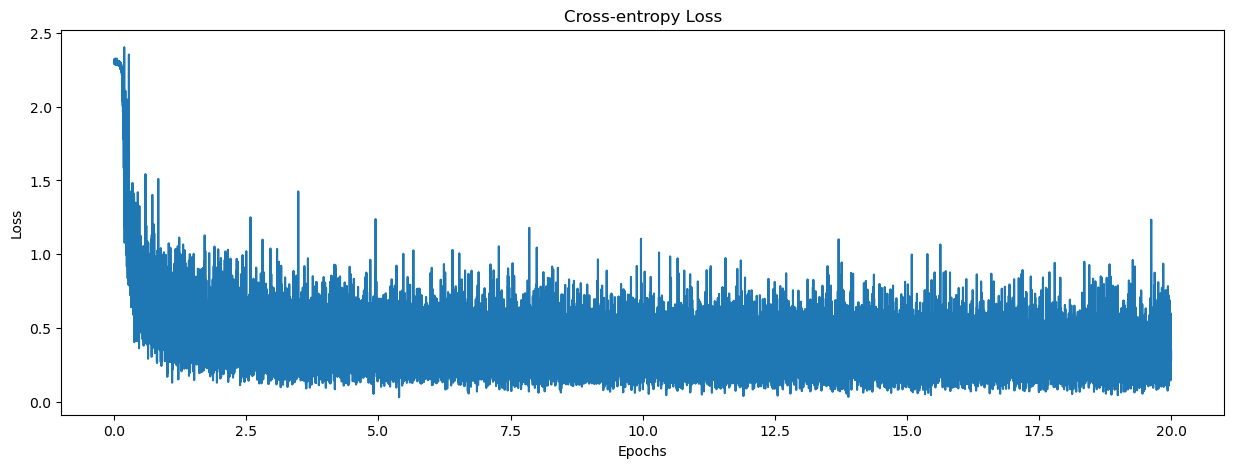

In [116]:
# Show the change in CE loss for the 20 epochs
step = np.linspace(0, num_epochs, 30000)
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(step, np.array(loss_values))
plt.title("Cross-entropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [154]:
# Store optimization trajectory for use in problem 4
trajectory = []
trajectory.append(model.input.weight.tolist())
trajectory.append(model.input.bias.tolist())
trajectory.append(model.layer1.weight.tolist())
trajectory.append(model.layer1.bias.tolist())
trajectory.append(model.layer2.weight.tolist())
trajectory.append(model.layer2.bias.tolist())
trajectory.append(model.layer3.weight.tolist())
trajectory.append(model.layer3.bias.tolist())
if(best_num_hidden_layers == 4):
    trajectory.append(model.layer4.weight.tolist())
    trajectory.append(model.layer4.bias.tolist())
elif(best_num_hidden_layers == 5):
    trajectory.append(model.layer4.weight.tolist())
    trajectory.append(model.layer4.bias.tolist())
    trajectory.append(model.layer5.weight.tolist())
    trajectory.append(model.layer5.bias.tolist())
print(trajectory)

# Flatten the trajectory list
trajectory = sum(trajectory, [])
# print(np.array(trajectory).shape)

[[[0.025562092661857605, 0.026948900893330574, 0.02180115506052971, 0.012041660957038403, 0.013975194655358791, -0.0036584879271686077, -0.0008520858827978373, -0.005320343188941479, 0.02607182040810585, -0.0022891038097441196, -0.13135990500450134, -0.0582505501806736, -0.06501457840204239, 0.19086900353431702, 0.17799894511699677, -0.03511418402194977, 0.05462600663304329, 0.021444473415613174, 0.002671359106898308, 0.13002093136310577, 0.14361543953418732, 0.059776630252599716, 0.04377114400267601, 0.011966226622462273, 0.014543086290359497, 0.016934407874941826, 0.026790302246809006, 0.025358539074659348, 0.02749479003250599, 0.02599180117249489, 0.013188846409320831, 0.0003565718652680516, -0.0170158538967371, -0.049275632947683334, -0.09755834192037582, -0.11226188391447067, -0.1404184103012085, -0.014932067133486271, 0.1885353922843933, 0.21611401438713074, -0.07495938241481781, 0.05133865401148796, 0.16408345103263855, 0.08273901045322418, 0.09122861921787262, 0.196629598736763

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (500,) + inhomogeneous part.

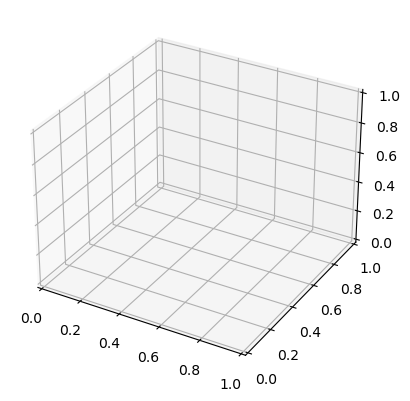

In [159]:
# Problem 4

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def plotSGDPath (trainX, trainY, trajectory):
    # TODO: change this toy plot to show a 2-d projection of the weight space
    # along with the associated loss (cross-entropy), plus a superimposed 
    # trajectory across the landscape that was traversed using SGD. Use
    # sklearn.decomposition.PCA's fit_transform and inverse_transform methods.

    # Calculate cross entropy to plot it
    def toyFunction (x1, x2):
        loss = -np.mean(np.dot(x1.T, np.log(x2)) + np.dot((1 - x1).T, np.log(1 - x2)))
        return loss

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    pca = PCA(n_components=2)
    pca.fit(trajectory)
    transformed_weights = pca.transform(trajectory)
    
    axis1 = transformed_weights[:, 0]
    axis2 = transformed_weights[:, 1]
    Xaxis, Yaxis = np.meshgrid(axis1, axis2)
    Zaxis = np.zeros((len(axis1), len(axis2)))
    for i in range(len(axis1)):
        for j in range(len(axis2)):
            Zaxis[i,j] = toyFunction(Xaxis[i,j], Yaxis[i,j])
    ax.plot_surface(Xaxis, Yaxis, Zaxis, alpha=0.6)

    Xaxis = 2*np.pi*np.random.random(8) - np.pi  # Just an example
    Yaxis = 2*np.pi*np.random.random(8) - np.pi  # Just an example
    Zaxis = toyFunction(Xaxis, Yaxis)
    ax.scatter(Xaxis, Yaxis, Zaxis, color='r')

    plt.show()

trainX = x_train
trainY = y_train

# trajectory has been defined in the previous cell from the problem 3 network

plotSGDPath(trainX, trainY, trajectory)

# We had issues trying to utilize the trajectory obtained from problem 3 and problem 2, but we have tried to implement the rest of the lines of code required for this function
# Please take a look to see if those functions have been written correctly despite the issues with input for the function
# Thank you